<a href="https://colab.research.google.com/github/jardunn/ForTheBirds-EdenToAddo/blob/main/forTheBirds_E2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install Basemap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import json

#For the birds: The influence of conservation corridors on bird conservation

#Eden to Addo Corridors¶

The area covered by the Eden to Addo Corridor is stored as a shape file. In this section we use the shape file to determine which pentads from SABAP2 are:

1. Contained: The for corners of the pentad fall within the corridor.
2. Overlap: Of the four corners defininf the pentad at lest 1 corner is inside the corridor and at lest one corner is outside the corridor boundary.
3. Neighbour: None of the pentad corners fall witin the boundary but the pentad shares at least one side with an Overlapping pentad.



In [3]:
# Read in Eden to Addo Shape Files
e2a_shape_broad_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Broad_Corridors_12Feb2025.shp').to_crs(epsg=4326)
e2a_shape_site_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Sites_12Feb2025.shp')
e2a_shape_df = pd.concat([e2a_shape_broad_df, e2a_shape_site_df])
e2a_shape_df.shape

(14, 16)

In [163]:
# Read in SA Protected Areas Data (SAPAD): https://egis.environment.gov.za/data_egis/data_download/current
SAPAD_shape_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SAPAD_OR_2024_Q3/SAPAD_OR_2024_Q3.shp')
# Remove Noorsveld reserve to rather use the Eden to Addo site
SAPAD_shape_df = SAPAD_shape_df[SAPAD_shape_df.CUR_NME.apply(lambda x: 'Noorsveld' not in x)]
print(f'SAPAD Shape: {SAPAD_shape_df.shape}')


SAPAD Shape: (1663, 11)


In [5]:
# Read in Town Names
with open('/content/drive/MyDrive/ForTheBirds-E2A/SA_map/za.json', 'r') as f:
    town_names = json.load(f)
    f.close()

In [6]:
def inBounds(loc, lower_left, upper_right):
    #print(f'{loc}, ll: ${lower_left}, ur: ${upper_right}')
    return (lower_left[0] <= loc[1] <= upper_right[0]) and (lower_left[1] <= loc[0] <= upper_right[1])

def annotate(text, lat, lon):
    x, y = m(lon, lat)
    plt.text(x, y, text)

def addPlaceNames(places, lower_left, upper_right, population_threshold=None):
    places = [pt for pt in town_names if inBounds((float(pt.get('lat')), float(pt.get('lng'))), lower_left, upper_right)]
    if (population_threshold is not None):
        places = [pt for pt in places if int(pt.get('population', '0')) > population_threshold]
    for place in places:
        annotate(place.get('city'), float(place.get('lat')), float(place.get('lng')))

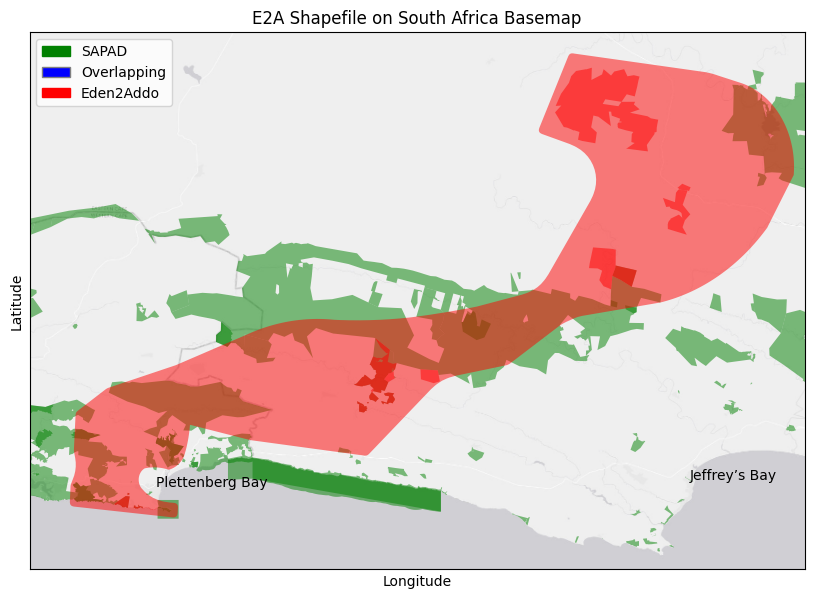

In [164]:
# prompt: plot e2a_shape_df with a base map of south africa

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap

# Assuming e2a_shape_df is already defined as in your previous code

# Define the bounds of South Africa (adjust if needed)
min_lon, min_lat = 23, -34.25#20, -34.25#23, -34.25 # approximate min longitude and latitude for South Africa
max_lon, max_lat = 25.25, -32.95#30, -20#25.25, -32.95 # approximate max longitude and latitude for South Africa

# Create the basemap
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Add coastlines and other map features
#m.drawcoastlines()
#m.drawcountries()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents()

# Plot the e2a_shape_df data on the basemap
SAPAD_shape_df.plot(ax=ax, color='green', alpha=0.5) # Plot the shapefile
e2a_shape_df.plot(ax=ax, color='red', alpha=0.5) # Plot the shapefile
#pentad_gdf[pentad_gdf.pentad == '3345_2350'].plot(ax=ax, color='green')
#pentad_gdf[pentad_gdf.pentad == '3355_2350'].plot(ax=ax, color='blue')
#pentad_gdf[pentad_gdf.pentad == '3400_2350'].plot(ax=ax, color='orange')

addPlaceNames(town_names, (min_lon, min_lat), (max_lon, max_lat))

# Add a title and labels
plt.title('E2A Shapefile on South Africa Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='SAPAD')
red_patch = mpatches.Patch(color='red', label='Eden2Addo')
plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper left')

plt.show()


## Classify Pentads
We want to classify our pentads by first looking at where the corner points lie relative to the border of the borader corridor.

This can be done using the `contains` and `overlaps` Geopandas methods.

In [361]:
# Read in SABAP2 Pentad GeoJson
pentad_gdf = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/SABAP2_geojson.json')
pentad_gdf = pentad_gdf.to_crs(epsg=4326)

In [362]:
pentad_gdf.head()

,pentad,full protocol,full protocol_total_hours,adhoc protocol,incidental,additional information,2007,2008,2009,2010,...,2018,2019,2020,2021,2022,2023,2024,2025,format,geometry
0,0825_3025,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,geoJSON,"MULTIPOLYGON (((30.4167 -8.41667, 30.50003 -8...."
1,0900_2900,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((29 -9, 29.08333 -9, 29.08333 -..."
2,0900_3125,1,7,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,geoJSON,"MULTIPOLYGON (((31.4167 -9, 31.50003 -9, 31.50..."
3,0920_2840,2,6,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.33333, 28.75003 -9...."
4,0930_2840,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.5, 28.75003 -9.5, 2..."


In [363]:
# Decrease shapes to consider by filtering to coarse bounding box
def filter_to_bounding_box(df, bounding_box):
    return df[df.geometry.apply(lambda row: (bounding_box.contains(row) or bounding_box.overlaps(row)))]

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
e2a_SAPAD_df = filter_to_bounding_box(SAPAD_shape_df, bounding_box)
e2a_pentad_gdf = filter_to_bounding_box(pentad_gdf, bounding_box)
# Create a single area of SAPAD data
e2a_SAPAD_area = e2a_SAPAD_df.dissolve()
e2a_site_area = e2a_shape_site_df.dissolve()

In [364]:
# Classify Pentads
def classify_pentad(pentad_geometry, corridor_boundary, protected_areas):
  '''
  Classify SABAP2 pentads according in relation to the E2A corridor
  '''
  if corridor_boundary.contains(pentad_geometry):
    return 'contained'
  elif corridor_boundary.overlaps(pentad_geometry):
    return 'overlapping'
  else:
    return 'external'

def inc_coordinate(coord, value):
  seconds = int(coord[2:])
  minutes = int(coord[:2])
  new_seconds = seconds + value

  if new_seconds < 0:
    minutes -= 1
  elif seconds + value >= 60:
    minutes += 1
  return f'{minutes}{new_seconds % 60:02d}'

def is_neighbour(pentad_row, pentad_df):
  if pentad_row.corridor_status != 'external':
    return False
  pentad_name = pentad_row.pentad
  lat, lon = pentad_name.split('_')
  # Names for pentads to the North, South, East and West
  adjacent_pentad_names = [
      f'{inc_coordinate(lat, 5)}_{lon}',
      f'{inc_coordinate(lat, -5)}_{lon}',
      f'{lat}_{inc_coordinate(lon, 5)}',
      f'{lat}_{inc_coordinate(lon, -5)}'
  ]

  # Check adjacent pentads
  for adjacent_pentad_name in adjacent_pentad_names:
    adjacent_pentad = pentad_df[pentad_df.pentad == adjacent_pentad_name]
    # Check if the adjacent pentad exists and the corridor status if it exists.
    if adjacent_pentad.shape[0] > 0 and (adjacent_pentad.iloc[0].corridor_status == 'contained' or adjacent_pentad.iloc[0].corridor_status == 'overlapping'):
      return True
  return False

# First Pass: Classify as Internal, Overlapping, or External
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_pentad(row, corridor_boundary, e2a_SAPAD_df))
# Second Pass: Classify as Neighbouring if adjacent to an Internal or Overlapping Pentad
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.apply(lambda row: 'neighbour' if is_neighbour(row, e2a_pentad_gdf) else row.corridor_status, axis=1)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


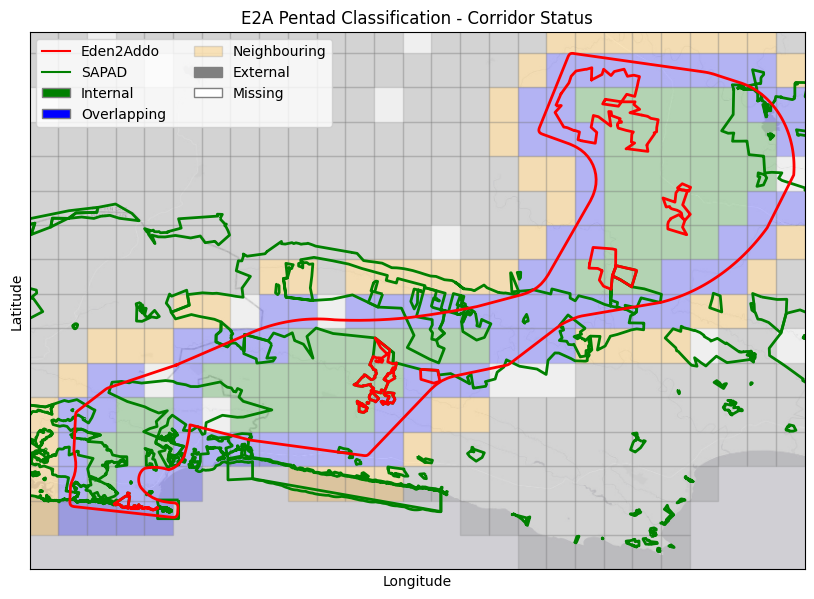

In [365]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


## Add Protected Area to Pentads
Use SAPAD regions to mark pentads as protected if they intersect with a protected area.

In [366]:
def classify_protected(pentad_geometry, protected_areas):
  for area in protected_areas:
    if area.overlaps(pentad_geometry).any() or area.contains(pentad_geometry).any():
      return True
  return False

e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_protected(row, [e2a_SAPAD_df, e2a_shape_site_df]))

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [367]:
e2a_pentad_gdf['percentage_protected'] = e2a_pentad_gdf.geometry.apply(
    lambda polygon: (polygon.intersection(e2a_SAPAD_area.geometry.iloc[0]).area + polygon.intersection(e2a_site_area.geometry.loc[0]).area) / polygon.area
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


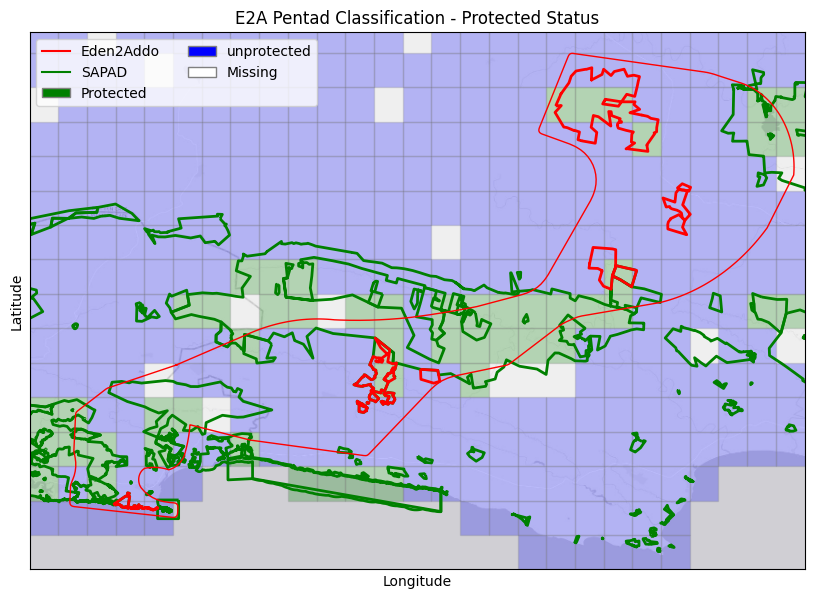

In [368]:
def protected_colour(protected):
  return 'green' if protected else 'blue'

def protected_percentage(percentage, threshold=0.9):
  return 'green' if percentage > threshold else 'blue'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.percentage_protected.apply(lambda x: protected_percentage(x, 0.5)), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_site_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile
e2a_shape_broad_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=1) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Protected Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Protected')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='unprotected')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, green_patch, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

# Pentad Statistics

In [371]:
e2a_with_external = e2a_pentad_gdf.copy()
e2a_pentad_gdf = e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external']

In [372]:
e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})

<ipython-input-372-1010d76bf171>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})


,pentad,full protocol
corridor_status,,
contained,55,605
neighbour,49,1651
overlapping,78,2608


In [373]:
e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})

<ipython-input-373-e0b18bb4fdbb>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})


,pentad,full protocol
protected,,
False,54,412
True,128,4452


In [374]:
# Create the matrix
matrix_data = []

for protected_status in e2a_pentad_gdf['protected'].unique():
  row = []
  for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
    subset = e2a_pentad_gdf[(e2a_pentad_gdf['protected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
    full_protocol_sum = subset['full protocol'].sum()
    row.append(full_protocol_sum)
  matrix_data.append(row)

# Create a DataFrame from the matrix
matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['protected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
row_totals = matrix_df.sum(axis=1)
col_totals = matrix_df.sum(axis=0)

# Add row totals as a new column
matrix_df['Total'] = row_totals

# Add column totals as a new row
matrix_df.loc['Total'] = col_totals

matrix_df

,neighbour,overlapping,contained,Total
False,186.0,109.0,117.0,412.0
True,1465.0,2499.0,488.0,4452.0
Total,1651.0,2608.0,605.0,NaN


In [375]:
## Matric where protected is defined by more than 50%
# Create the matrix
matrix_data = []

e2a_pentad_gdf['pprotected'] = e2a_pentad_gdf.percentage_protected.apply(lambda x: 'protected' if x > 0.5 else 'unprotected')
for protected_status in e2a_pentad_gdf['pprotected'].unique():
  row = []
  for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
    subset = e2a_pentad_gdf[(e2a_pentad_gdf['pprotected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
    full_protocol_sum = subset['full protocol'].sum()
    row.append(full_protocol_sum)
  matrix_data.append(row)

# Create a DataFrame from the matrix
matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['pprotected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
row_totals = matrix_df.sum(axis=1)
col_totals = matrix_df.sum(axis=0)

# Add row totals as a new column
matrix_df['Total'] = row_totals

# Add column totals as a new row
matrix_df.loc['Total'] = col_totals

matrix_df

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,neighbour,overlapping,contained,Total
unprotected,412.0,2415.0,318.0,3145.0
protected,1239.0,193.0,287.0,1719.0
Total,1651.0,2608.0,605.0,NaN


In [376]:
e2a_pentad_gdf.head()

,pentad,full protocol,full protocol_total_hours,adhoc protocol,incidental,additional information,2007,2008,2009,2010,...,2022,2023,2024,2025,format,geometry,corridor_status,protected,percentage_protected,pprotected
18115,3255_2430,1,2,3,0,0,0,0,0,0,...,0,0,0,0,geoJSON,"MULTIPOLYGON (((24.5 -32.91667, 24.5833 -32.91...",neighbour,False,0.0,unprotected
18116,3255_2435,6,13,8,0,0,0,0,0,0,...,0,0,0,0,geoJSON,"MULTIPOLYGON (((24.58333 -32.91667, 24.66663 -...",neighbour,False,0.0,unprotected
18117,3255_2440,5,11,16,0,0,0,0,0,0,...,0,0,0,0,geoJSON,"MULTIPOLYGON (((24.66667 -32.91667, 24.74997 -...",neighbour,False,0.0,unprotected
18118,3255_2445,5,10,0,0,0,0,0,0,0,...,0,0,0,0,geoJSON,"MULTIPOLYGON (((24.75 -32.91667, 24.8333 -32.9...",neighbour,False,0.0,unprotected
18119,3255_2450,10,35,4,0,0,0,1,0,0,...,0,0,0,0,geoJSON,"MULTIPOLYGON (((24.83333 -32.91667, 24.91663 -...",neighbour,False,0.0,unprotected


In [377]:
matrix_data = []
for protected_status in e2a_pentad_gdf['protected'].unique():
  row = []
  for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
    subset = e2a_pentad_gdf[(e2a_pentad_gdf['protected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
    full_protocol_sum = subset['pentad'].count()
    row.append(full_protocol_sum)
  matrix_data.append(row)

# Create a DataFrame from the matrix
matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['protected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
row_totals = matrix_df.sum(axis=1)
col_totals = matrix_df.sum(axis=0)

# Add row totals as a new column
matrix_df['Total'] = row_totals

# Add column totals as a new row
matrix_df.loc['Total'] = col_totals

matrix_df

,neighbour,overlapping,contained,Total
False,22.0,16.0,16.0,54.0
True,27.0,62.0,39.0,128.0
Total,49.0,78.0,55.0,NaN


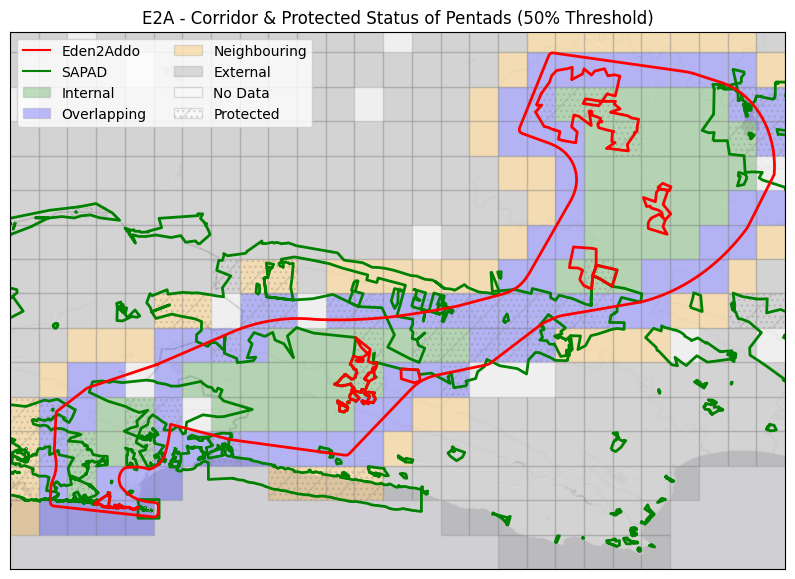

In [379]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'


fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
# Potected
e2a_with_external[e2a_with_external.percentage_protected > 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected > 0.5].apply(corridor_colour), hatch='/...', edgecolor='grey', alpha=0.25)
e2a_with_external[e2a_with_external.percentage_protected <= 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected <= 0.5].apply(corridor_colour), edgecolor='grey', alpha=0.25)
SAPAD_area.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A - Corridor & Protected Status of Pentads (50% Threshold)')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', alpha=0.25, label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', alpha=0.25, label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', alpha=0.25, label='No Data')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='grey', hatch='/...', alpha=0.25, label='Protected')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch, hatch_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()